In [1]:
#import basic required packages
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(context="notebook", palette="colorblind", style = 'darkgrid' ,font_scale = 2, color_codes=True)

import plotly.express as px

from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import another important packages
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score

from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score

In [3]:
#import ready to preprocessed data set
our_df = pd.read_csv('manipulated_features.csv')
preprocess_it = our_df.drop(columns=['Case Fatality Rate', 'Case Recovered Rate']).set_index('Province')
preprocess_it.head()

,New Active Cases Agg,New Recovered Agg,New Deaths Agg
Province,,,
Aceh,0.000237,0.001362,0.000068
Bali,0.001103,0.002958,0.000110
Banten,0.000699,0.000952,0.000038
Bengkulu,0.000466,0.001280,0.000056
DKI Jakarta,0.001407,0.015189,0.000300


Previously, on data preparation stage we divide New Active Cases, New Recovered, and New Deaths by its Population to reduce variation. By doing this, our 5 features will spread between 0.000030 - 0.79

In [4]:
#descriptive statistics of features used
preprocess_it.describe().loc[['mean', 'min', '50%', 'max', 'std']].T

,mean,min,50%,max,std
New Active Cases Agg,0.000615,0.000064,0.000395,0.002864,0.000589
New Recovered Agg,0.002426,0.000222,0.001790,0.015189,0.002607
New Deaths Agg,0.000075,0.000005,0.000068,0.000300,0.000058


In [5]:
#data set information
preprocess_it.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, Aceh to Sumatera Utara
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   New Active Cases Agg  34 non-null     float64
 1   New Recovered Agg     34 non-null     float64
 2   New Deaths Agg        34 non-null     float64
dtypes: float64(3)
memory usage: 1.1+ KB


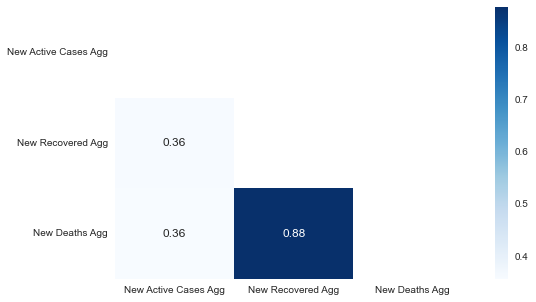

In [6]:
#check correlation matrix
corr = preprocess_it.corr()
plt.figure(figsize=(8,5))
#masking the upper triangle part (since matrix is repetitive)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="Blues", annot=True)
plt.show()

There's strong positive correlation between New Deaths and New Recovered. On the other hand, New Deaths and New Active Cases, also New Recovered, and New Active Cases show weak positive correlation.

# Check the distribution of each features

Distribution plot of: New Active Cases Agg


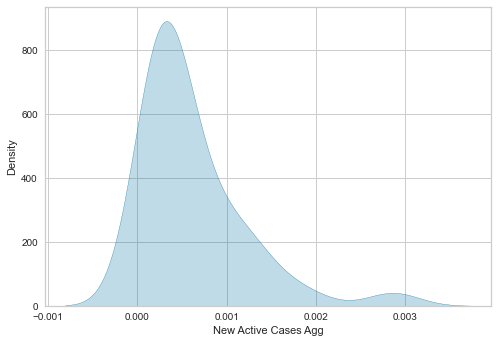

Distribution plot of: New Recovered Agg


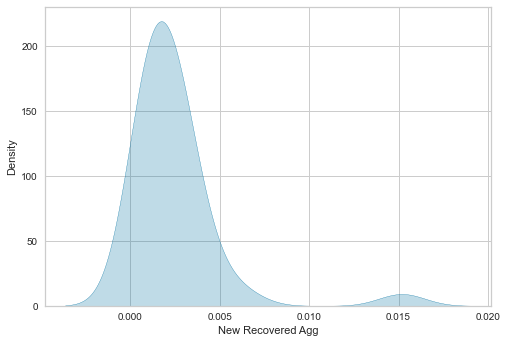

Distribution plot of: New Deaths Agg


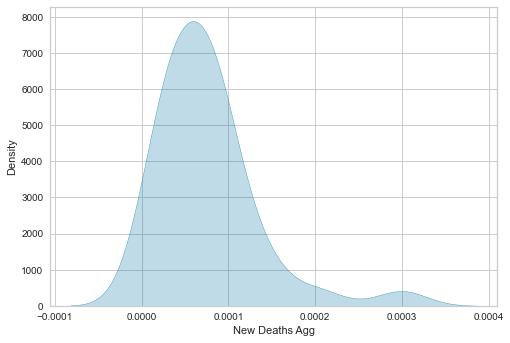

In [7]:
#Using kdeplot
df1 = preprocess_it.columns

for i, var in enumerate(df1):
    print('Distribution plot of:', var)
    sns.kdeplot(preprocess_it[var], shade=True, color="b")
    plt.show()

Those variables are skewed to the right.

# Standarization

Even if our features already spread in the same unit, we still need to conduct StandardScaler because KMeans used distance-based measurements to determine the similarity between data points. If we didn't standarize it, then our cluster result won't be valid. Outliers will be grouped into its unique cluster.

In [8]:
#copy data set
target = preprocess_it.copy()
target.head()

,New Active Cases Agg,New Recovered Agg,New Deaths Agg
Province,,,
Aceh,0.000237,0.001362,0.000068
Bali,0.001103,0.002958,0.000110
Banten,0.000699,0.000952,0.000038
Bengkulu,0.000466,0.001280,0.000056
DKI Jakarta,0.001407,0.015189,0.000300


In [9]:
#standardize it
scaler = StandardScaler()

scaler.fit(target)

target_scaled = scaler.transform(target)

target_scaled = pd.DataFrame(target_scaled, columns=target.columns)
target_scaled.head()

,New Active Cases Agg,New Recovered Agg,New Deaths Agg
0,-0.652421,-0.414489,-0.118627
1,0.840929,0.206911,0.608824
2,0.145263,-0.573943,-0.651544
3,-0.257151,-0.446169,-0.339740
4,1.365401,4.968986,3.906262


Distribution plot of: New Active Cases Agg


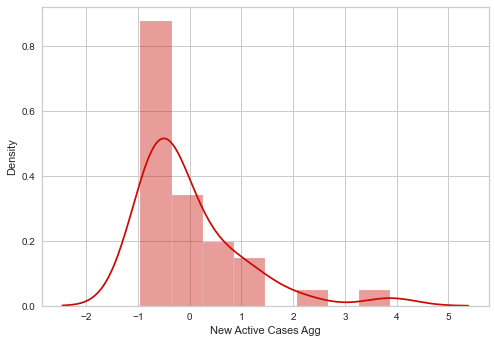

Distribution plot of: New Recovered Agg


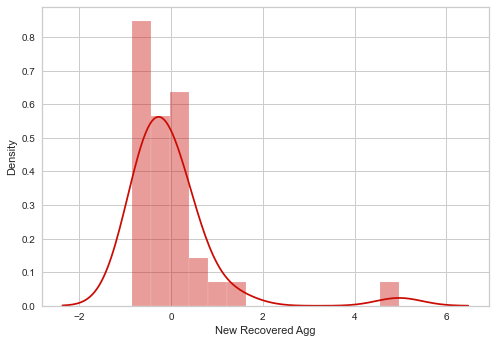

Distribution plot of: New Deaths Agg


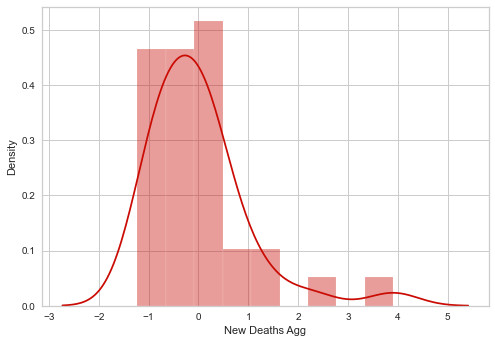

In [10]:
#draw distplot to see standardized result
for i, var in enumerate(target_scaled):
    print('Distribution plot of:', var)
    sns.distplot(target_scaled[var], color="r")
    plt.show()
#standarization doesn't change the varible's distribution, it's only change the scale

In [11]:
#descriptive statistics of scaled features
target_scaled.describe().loc[['mean', 'min', '50%', 'max', 'std']].T

,mean,min,50%,max,std
New Active Cases Agg,-4.244970e-17,-0.949929,-0.379447,3.877680,1.015038
New Recovered Agg,1.632681e-17,-0.858310,-0.247534,4.968986,1.015038
New Deaths Agg,-1.012262e-16,-1.225048,-0.120132,3.906262,1.015038


## Decide optimal number of k

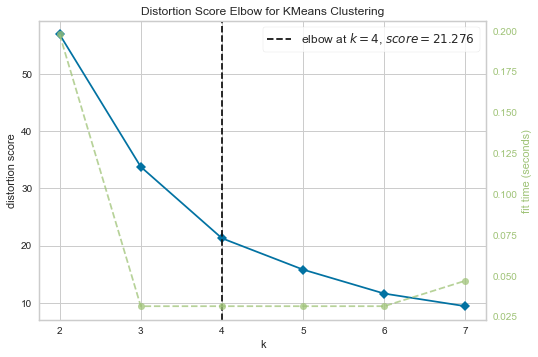

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
#using Elbow Method
Elbow_fast = KElbowVisualizer(KMeans(random_state=42), k=7)
Elbow_fast.fit(target_scaled)
Elbow_fast.show()

#according to below plot, it would be better to use k=4

## KMeans Clustering

In [13]:
#fit
kmeans_4 = KMeans(n_clusters=4, init='k-means++', max_iter=7)
kmeans_4.fit(target_scaled)

#predict
pred_4 = kmeans_4.predict(target_scaled)

#save it to origin preprocess_it df
preprocess_it['Cluster'] = pred_4

#save it to new df
clus_result = preprocess_it
clus_result

,New Active Cases Agg,New Recovered Agg,New Deaths Agg,Cluster
Province,,,,
Aceh,0.000237,0.001362,0.000068,1
Bali,0.001103,0.002958,0.000110,3
Banten,0.000699,0.000952,0.000038,1
Bengkulu,0.000466,0.001280,0.000056,1
DKI Jakarta,0.001407,0.015189,0.000300,2
Daerah Istimewa Yogyakarta,0.001020,0.002252,0.000072,3
Gorontalo,0.000366,0.002802,0.000086,3
Jambi,0.000244,0.000664,0.000016,1
Jawa Barat,0.000257,0.001567,0.000026,1


In [14]:
#how many member in each cluster?
frame = pd.DataFrame(target_scaled)
frame['cluster'] = pred_4
frame['cluster'].value_counts()

1    18
3    12
0     3
2     1
Name: cluster, dtype: int64

In [43]:
#percentage of member per cluster
clus_0 = print(3/34)
clus_1 = print(18/34)
clus_2 = print(1/34)
clus_3 = print(12/34)

0.08823529411764706
0.5294117647058824
0.029411764705882353
0.35294117647058826


**So, the member of each cluster are:**


* Cluster 0: 3 Province consist of Kalimantan Tengah, Kalimantan Utara, Papua


* Cluster 1: 18 Province consist of Aceh, Banten, Bengkulu, Jambi, Jawa Barat, Kalimantan Barat, Kepulauan Bangka Belitung, Lampung, Maluku, Maluku Utara, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Barat, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sumatera Selatan, Sumatera Utara


* Cluster 2: 1 Province which is DKI Jakarta


* Cluster 3: 12 Province which is Bali, Daerah Istimewa Yogyakarta, Gorontalo, Jawa Tengah, Jawa Timur, Kalimantan Selatan, Kalimantan Timur, Kepulauan Riau, Papua Barat, Riau, Sulawesi Utara, Sumatera Barat

### Attributes of KMeans after calling .fit()

In [17]:
kmeans_4.inertia_ #The lowest SSE value as we have seen in the previous KElbowVisualizer

21.275780357049904

In [18]:
kmeans_4.cluster_centers_ #Final locations of the centroid

array([[ 2.45020957, -0.11692301, -0.15933313],
       [-0.49520555, -0.461119  , -0.60905347],
       [ 1.36540139,  4.96898552,  3.90626216],
       [ 0.01647248,  0.30682712,  0.62789163]])

In [19]:
kmeans_4.n_iter_ #the number of iterations required to converge

4

In [20]:
#source: https://github.com/Suwarti/Customer-Segmentation/blob/main/Suwarti_Final_Project.ipynb
#define function to draw cluster result for different k

def kmeans(target_scaled, clusters_number, preprocess_it):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 42)
    kmeans.fit(target_scaled)

    #Extract cluster labels
    cluster_labels = kmeans.labels_
        
    #Create a cluster label column in original dataset
    df_new = preprocess_it.assign(Cluster = cluster_labels)
    
    #Initialise TSNE
    model = TSNE(random_state=42)
    transformed = model.fit_transform(df_new)
    
    #Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

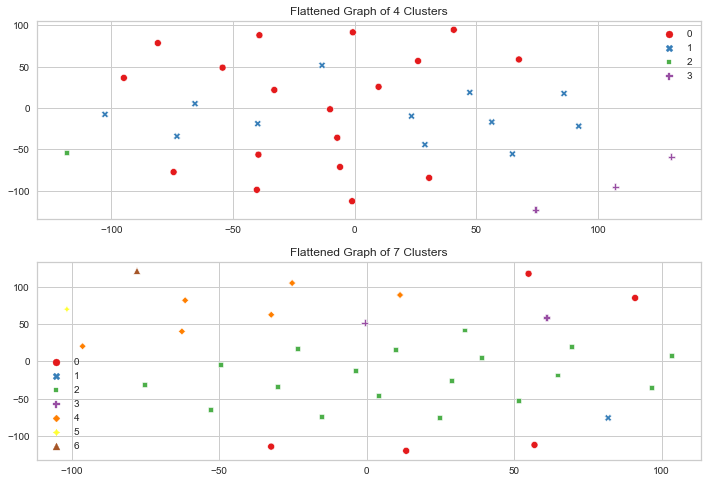

In [21]:
#show plot
plt.figure(figsize=(10, 10))

#4 clusters
plt.subplot(3, 1, 1)
df_k4 = kmeans(target_scaled, 4, preprocess_it)

#7 clusters
plt.subplot(3, 1, 2)
df_k7 = kmeans(target_scaled, 7, preprocess_it)

plt.tight_layout()

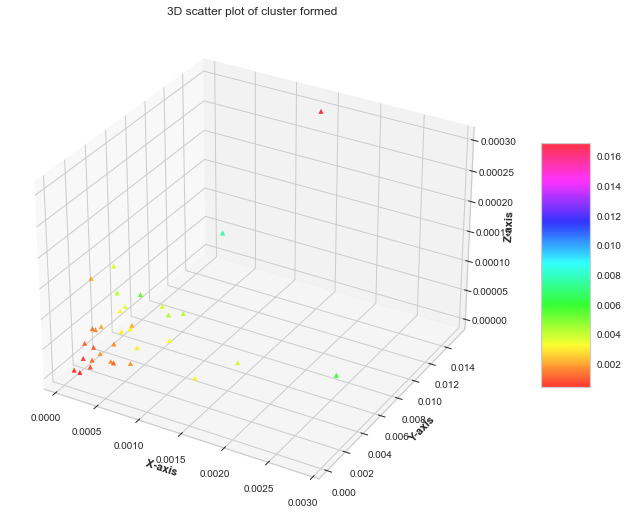

In [22]:
#source: https://www.geeksforgeeks.org/3d-scatter-plotting-in-python-using-matplotlib/
#draw 3D cluster plot

x = clus_result["New Active Cases Agg"]
y = clus_result["New Recovered Agg"]
z = clus_result["New Deaths Agg"]

#Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

#Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

#Creating color map
cmap_ = plt.get_cmap('hsv')
 
#Creating plot
scatter = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = cmap_,
                    marker ='^')
 
plt.title("3D scatter plot of cluster formed")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scatter, ax = ax, shrink = 0.5, aspect = 5)
 
#show plot
plt.show()

# Evaluating The Model

In [16]:
X = np.asarray(target_scaled)

#evaluation for k=4
#using silhouette score
sil_score = silhouette_score(X, kmeans_4.labels_, metric='euclidean')
#using davies bouldin score
dav_score = davies_bouldin_score(X, kmeans_4.labels_)

print('Silhouette Score: %.3f' % sil_score)
print('Davies Bouldin Score: %.3f' % dav_score)

Silhouette Score: 0.601
Davies Bouldin Score: 0.441


* Higher Silhouette Score indicates the clusters are very dense and nicely separated. This scores from -1 to 1.

* Lower Davies Bouldin Score implies clusters which are farther apart and less dispersed, it's bounded from -0 to 1. 

In [24]:
#aggregate features in each cluster
def clusters_char(df):
    
    k4_result = clus_result.groupby(['Cluster']).agg({
        'New Active Cases Agg': 'mean',
        'New Recovered Agg': 'mean',
        'New Deaths Agg': 'mean',
    })
    
    return k4_result

In [25]:
#show the result
final_result = clusters_char(clus_result)
final_result.reset_index()

,Cluster,New Active Cases Agg,New Recovered Agg,New Deaths Agg
0,0,0.002036,0.002126,0.000066
1,1,0.000328,0.001242,0.000040
2,2,0.001407,0.015189,0.000300
3,3,0.000625,0.003214,0.000111


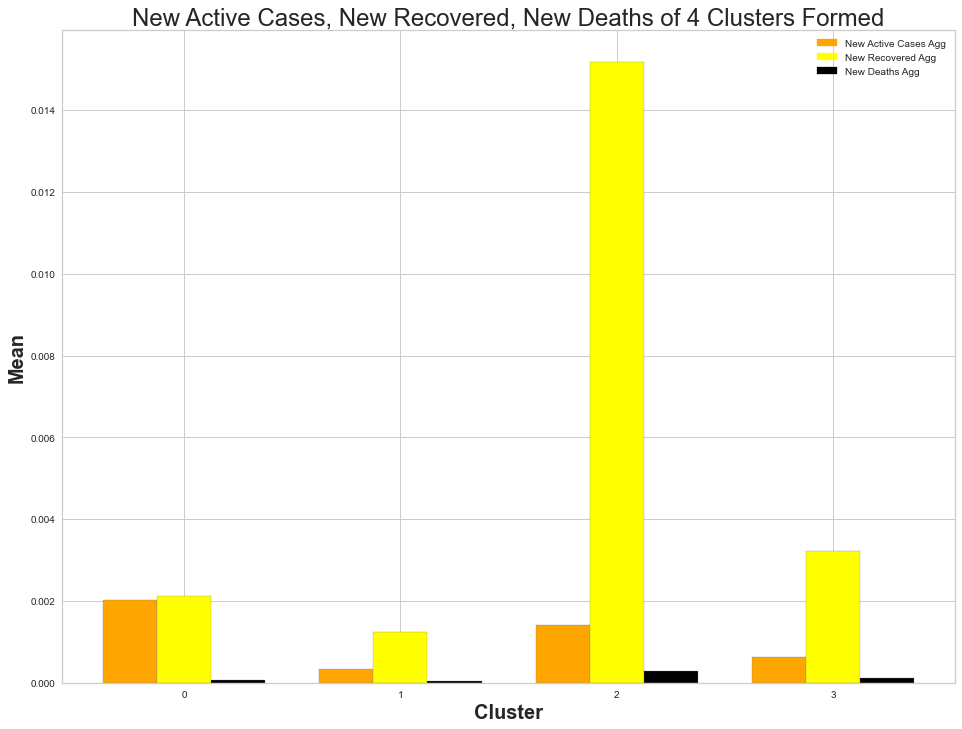

In [30]:
#plotting above aggregation
#set up legends
colors = {'New Active Cases Agg': 'orange',
         'New Recovered Agg': 'yellow',
         'New Deaths Agg': 'black'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

#set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(16, 12))

#set height of bar
NumActiveCases = final_result['New Active Cases Agg']
NumRecovered = final_result['New Recovered Agg']
NumDeaths = final_result['New Deaths Agg']

#set position of bar on X axis
br1 = np.arange(len(NumActiveCases))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

#make the plot
plt.bar(br1, NumActiveCases, color ='orange', width = barWidth,
        edgecolor ='grey', label ='NumActiveCases')
plt.bar(br2, NumRecovered, color ='yellow', width = barWidth,
        edgecolor ='grey', label ='NumRecovered')
plt.bar(br3, NumDeaths, color ='black', width = barWidth,
        edgecolor ='grey', label ='NumDeaths')

#adding Xticks
plt.title('New Active Cases, New Recovered, New Deaths of 4 Clusters Formed', fontsize = 24)
plt.xlabel('Cluster', fontweight ='bold', fontsize = 20)
plt.ylabel('Mean', fontweight ='bold', fontsize = 20)
plt.xticks([r + barWidth for r in range(len(NumActiveCases))],
        ['0', '1', '2', '3'])
 
plt.legend(handles, labels)
plt.show()

<AxesSubplot:>

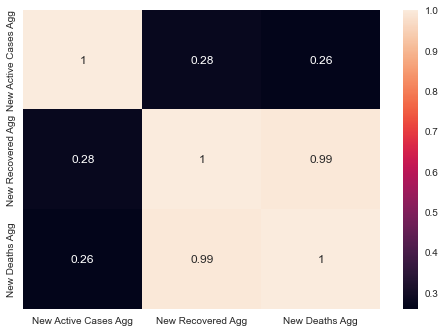

In [44]:
#heatmap of features that formed cluster
sns.heatmap(data=final_result.corr(), annot=True)

There's strong positive correlation between New Deaths and New Recovered. On the other hand, New Deaths and New Active Cases, also New Recovered, and New Active Cases show weak positive correlation.

<AxesSubplot:xlabel='Cluster', ylabel='count'>

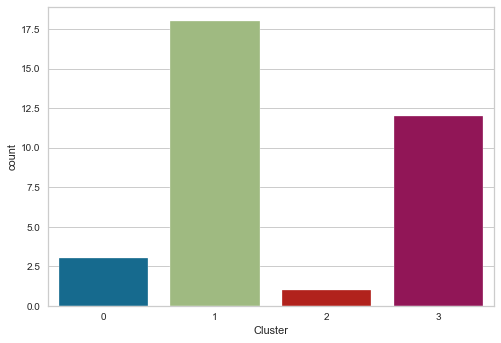

In [33]:
#count of member each cluster
sns.countplot(x=clus_result['Cluster'])

Cluster 1 has the highest number of member, then it's followed by cluster 3, cluster 0, and cluster 2.

<AxesSubplot:xlabel='Cluster', ylabel='New Active Cases Agg'>

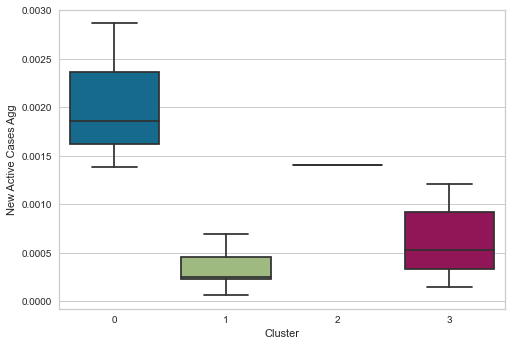

In [34]:
#draw boxplot of New Active Cases Agg per cluster
sns.boxplot(x=clus_result['Cluster'], y=clus_result['New Active Cases Agg'])

<AxesSubplot:xlabel='Cluster', ylabel='New Recovered Agg'>

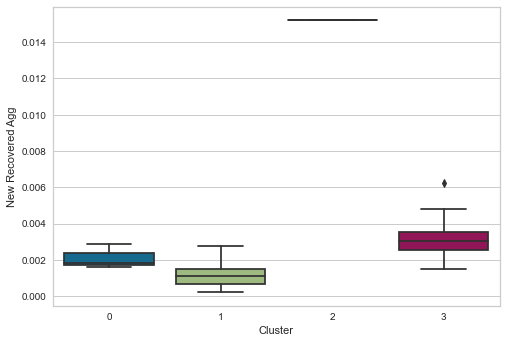

In [35]:
#draw boxplot of New Recovered Agg per cluster
sns.boxplot(x=clus_result['Cluster'], y=clus_result['New Recovered Agg'])

<AxesSubplot:xlabel='Cluster', ylabel='New Deaths Agg'>

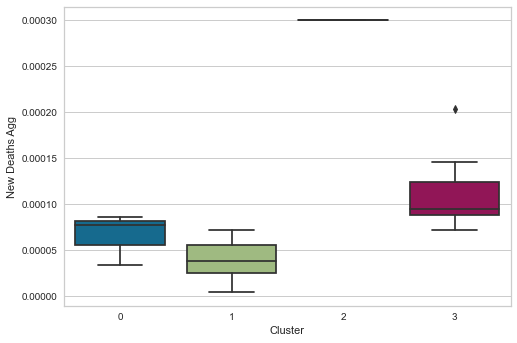

In [36]:
#draw boxplot of New Deaths Agg per cluster
sns.boxplot(x=clus_result['Cluster'], y=clus_result['New Deaths Agg'])

# Conclusion

**We will state 4 zones for our 4 clusters:**
* Zone A comprises of provinces with the most active Covid-19 transmission
* Zone B comprises of provinces with the second active Covid-19 transmission
* Zone C comprises of provinces with the third active Covid-19 transmission
* Zone D comprises of provinces with the least active Covid-19 transmission

**Disclaimer:**

Actually we want to grouping formed clusters into 4 categories (Green, Yellow, Orange, Red) according to real world zone described by the government. But, we can't do that because our cluster's characteristic don't meet the criteria so we describe our own zone according to its order from the most active Covid-19 transmission to the less active Covid-19 transmission.


1. **Cluster 0**
    * Consist of 3 Provinces: Kalimantan Tengah, Kalimantan Utara, Papua
    * It has the highest New Active Cases compared to the rest 3 clusters
    * New Recovered and New Deaths in this cluster is in the third position
    * It belongs to "Zone B"


2. **Cluster 1**
    * Consist of 18 Provinces: Aceh, Banten, Bengkulu, Jambi, Jawa Barat, Kalimantan Barat, Kepulauan Bangka Belitung, Lampung, Maluku, Maluku Utara, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Barat, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sumatera Selatan, Sumatera Utara
    * It has the lowest New Active Cases, New Recovered, New Deaths compared to another 3 clusters
    * It belongs to "Zone C"


3. **Cluster 2**
    * Consist of 1 Province: DKI Jakarta
    * New Active Cases in this cluster is the second highest
    * While, this cluster has the highest New Recovered, and New Deaths
    * It belongs to "Zone A"


4. **Cluster 3**
    * Consist of 12 Provinces: Bali, Daerah Istimewa Yogyakarta, Gorontalo, Jawa Tengah, Jawa Timur, Kalimantan Selatan, Kalimantan Timur, Kepulauan Riau, Papua Barat, Riau, Sulawesi Utara, Sumatera Barat
    * New Active Cases of this cluster is in the third position
    * New Recovered, and New Deaths are the second highest 
    * It belongs to "Zone D"

# Recommendation

Because our data set is historical data from March 2020 to December 2020, our recommendation can be implemented in the early of 2021.

After grouping 34 provinces into its 4 unique clusters based on 3 features used: New Active Cases, New Recovered, New Deaths. Now we're able to give recommendation for the Indonesia central government
to give the funding of Covid-19 Pandemic to the cluster with the most active transmission of Covid-19 and the second active transmission of Covid-19 firstly.

Hence, the funding of Covid-19 Pandemic can be given to DKI Jakarta, Kalimantan Tengah, Kalimantan Utara, Papua. The rest 30 Provinces will also obtain the funding of Covid-19 in the future once the government has already collected the funding of Covid-19 Pandemic, the amount of funding given should be considered (according to its zone).

In short, the Indonesia central government can distribute the funding of Covid-19 Pandemic by prioritizing the following order:
* Zone A, consist of DKI Jakarta

* Zone B, consist of Kalimantan Tengah, Kalimantan Utara, Papua

* Zone C, consist of Aceh, Banten, Bengkulu, Jambi, Jawa Barat, Kalimantan Barat, Kepulauan Bangka Belitung, Lampung, Maluku, Maluku Utara, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Barat, Sulawesi Tengah, Sulawesi Selatan, Sulawesi Tenggara, Sumatera Selatan, Sumatera Utara

* Zone D, consist of Bali, Daerah Istimewa Yogyakarta, Gorontalo, Jawa Tengah, Jawa Timur, Kalimantan Selatan, Kalimantan Timur, Kepulauan Riau, Papua Barat, Riau, Sulawesi Utara, Sumatera Barat

# Future Work

We will always discover different result of cluster's member, even if we use the same number of k. Once we're sure that we have already obtained the best result, then

1. Evaluate the model.
2. Don't waste more time to try the same algorithm with the same number of optimal k over and over again, utilize our time to thinking about possible features to use. In order to give better recommendation, we can add external data to strengthen our cluster's characteristic such as health service index per province, the number of medical facilities, the number of health workers, and so on. Not only that, from the given data set we can also consider to add another features.
2. Try another clustering algorithms, such as agglomerative clustering, DBSCAN, OPTICS, or even optimizing our existed model.

_Thanks for reading, we're waiting for your feedback._